# Estimating AR(1) using pytorch and my estimator

In [289]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np


class AR1(nn.Module):
    def __init__(self, phi=0.0, var=1.0):
        super(AR1, self).__init__()
        # Define the autoregressive parameter as a learnable parameter
        # Initializing it close to 1 (for simplicity)
        self.phi = nn.Parameter(torch.tensor([phi]))
        self.logvar = nn.Parameter(torch.log(torch.tensor([var])))

    def forward(self, sequence):
        """
        Predict the next value in the sequence based on the AR(1) model
        :param sequence: A 1D tensor of shape (sequence_length,)
        :return: A 1D tensor of predicted values of shape (sequence_length,)
        """

        predicted_values = [torch.zeros_like(sequence[:,0])]
        for t in range(sequence.shape[1] - 1):
            y_t = self.phi * sequence[:,t]
            predicted_values.append(y_t)

        return torch.stack(predicted_values, dim=1)


    def sample(self, num_samples, seq_length):
        """
        Generate samples using the AR(1) model
        :param num_samples: Number of samples to generate
        :param noise_std: Standard deviation of the noise term
        :return: A 1D tensor of generated samples
        """
        initial_value = torch.randn(num_samples)
        samples = [initial_value]
        current_value = initial_value
        for _ in range(seq_length - 1):  # subtract 1 since we already have the initial value
            noise = torch.randn(num_samples) * torch.sqrt(torch.exp(self.logvar))
            next_value = self.phi * current_value + noise
            samples.append(next_value)
            current_value = next_value

        return torch.stack(samples, dim=1)

# Example
model = AR1()
generated_samples = model.sample(num_samples=100, seq_length=9)
print(generated_samples.shape)



torch.Size([100, 9])


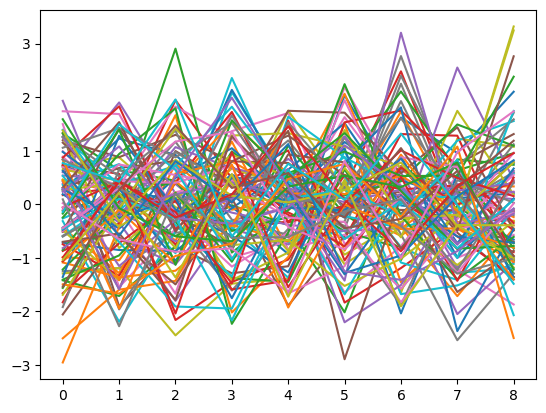

In [290]:
plt.plot(generated_samples.detach().T.numpy())
plt.show()

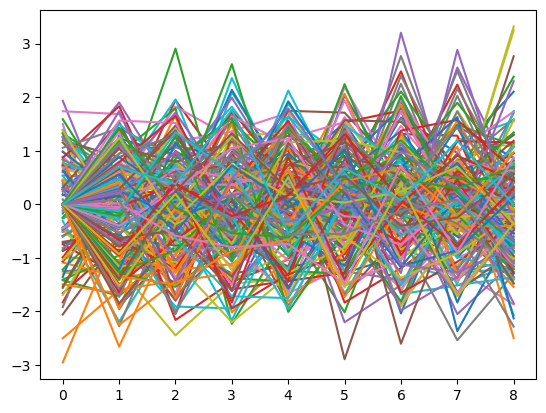

In [291]:
plt.plot(generated_samples.detach().T.numpy())

model.phi = nn.Parameter(torch.Tensor([.9]))

predicted_values = model(generated_samples)
plt.plot(predicted_values.detach().T.numpy())

plt.show()


In [292]:
model_true = AR1(phi=0.8, var = 0.5)

In [288]:
# Hyperparameters
learning_rate = 0.01
epochs = 1000
num_samples = 100
seq_length = 100

class myLoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, y, pred, y_sim, pred_sim, logvar):
        # return torch.mean(torch.pow(y-pred, 2)/torch.exp(logvar)) + logvar
        # return torch.mean(torch.pow(y-pred, 2)/torch.exp(logvar)) - torch.mean(torch.pow(y_sim-pred_sim, 2)/torch.exp(logvar)) + logvar
        # return -torch.mean(y*pred - y_sim*pred_sim)/torch.exp(logvar) + logvar/(y.shape[0] * y.shape[1])



# Simulate dataset (for the sake of this example)
# You can replace this with your actual dataset




with torch.no_grad():
    dataset = model_true.sample(num_samples = num_samples, seq_length = seq_length).detach()

# Loss and Optimizer
model = AR1(phi=0.0, var = 2.0)
criterion = nn.MSELoss()
criterion = myLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    # Forward pass
    outputs = model(dataset)

    with torch.no_grad():
        y_sim = model.sample(num_samples, seq_length)
    
    pred_sim = model(y_sim)
    loss = criterion(dataset, outputs, y_sim, pred_sim, model.logvar)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # Print loss every 100 epochs
    if (epoch+1) % 100 == 0:
        print(model.phi.item())
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, var: {torch.exp(model.logvar).item():.3f}')

print(f'Learned phi: {model.phi.item():.4f}')

0.0
Epoch [100/1000], Loss: -0.0000, var: 0.736
0.0
Epoch [200/1000], Loss: -0.0001, var: 0.271
0.0
Epoch [300/1000], Loss: -0.0002, var: 0.100
0.0
Epoch [400/1000], Loss: -0.0003, var: 0.037
0.0
Epoch [500/1000], Loss: -0.0004, var: 0.013
0.0
Epoch [600/1000], Loss: -0.0005, var: 0.005
0.0
Epoch [700/1000], Loss: -0.0006, var: 0.002
0.0
Epoch [800/1000], Loss: -0.0007, var: 0.001


KeyboardInterrupt: 

In [173]:
generated_samples

tensor([[ 1.2665e+00,  5.3075e-01,  4.5991e-01,  2.2141e+00, -4.6399e-01,
          6.7459e-02,  6.1775e-01,  3.7972e-02, -1.6717e+00],
        [-1.6227e+00,  9.9259e-02, -7.3355e-01, -2.6383e-01, -6.3564e-01,
          1.4829e+00, -7.2575e-01, -1.0915e+00, -1.6818e-01],
        [ 5.3240e-01,  3.2270e-01, -2.8131e-01, -9.7192e-01, -6.1739e-01,
          1.3199e+00, -1.4898e+00,  5.9580e-01, -5.3810e-01],
        [ 1.4296e+00, -1.4014e+00,  4.4033e-01, -9.2822e-01,  8.3406e-01,
         -1.3083e-01,  1.1557e+00,  2.8525e-02,  5.2125e-01],
        [-7.1196e-01, -7.3504e-01, -1.1313e+00, -8.4414e-01, -1.5834e+00,
         -7.4720e-01,  2.0443e-01, -8.1355e-01,  1.2025e+00],
        [-1.0551e+00, -5.4430e-01, -8.9755e-01, -1.2587e+00, -7.2086e-01,
          6.4378e-01, -4.4359e-01,  5.1109e-02,  1.7187e-01],
        [-2.9367e+00, -1.2626e+00, -1.4696e+00, -1.5057e+00,  1.0885e+00,
         -1.5689e+00,  2.1344e+00, -1.0793e-01, -8.3074e-01],
        [-1.2933e-01,  3.4673e-01,  1.8635e-01, 

In [174]:
predicted_values

tensor([[ 0.0000e+00,  1.1399e+00,  4.7767e-01,  4.1392e-01,  1.9927e+00,
         -4.1759e-01,  6.0713e-02,  5.5597e-01,  3.4175e-02],
        [ 0.0000e+00, -1.4604e+00,  8.9333e-02, -6.6020e-01, -2.3745e-01,
         -5.7207e-01,  1.3346e+00, -6.5318e-01, -9.8239e-01],
        [ 0.0000e+00,  4.7916e-01,  2.9043e-01, -2.5318e-01, -8.7473e-01,
         -5.5565e-01,  1.1879e+00, -1.3408e+00,  5.3622e-01],
        [ 0.0000e+00,  1.2866e+00, -1.2613e+00,  3.9630e-01, -8.3540e-01,
          7.5065e-01, -1.1775e-01,  1.0401e+00,  2.5672e-02],
        [ 0.0000e+00, -6.4076e-01, -6.6154e-01, -1.0182e+00, -7.5973e-01,
         -1.4250e+00, -6.7248e-01,  1.8399e-01, -7.3219e-01],
        [ 0.0000e+00, -9.4961e-01, -4.8987e-01, -8.0779e-01, -1.1328e+00,
         -6.4877e-01,  5.7941e-01, -3.9923e-01,  4.5998e-02],
        [ 0.0000e+00, -2.6431e+00, -1.1363e+00, -1.3227e+00, -1.3552e+00,
          9.7969e-01, -1.4120e+00,  1.9210e+00, -9.7140e-02],
        [ 0.0000e+00, -1.1640e-01,  3.1206e-01, 